In [1]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

## X and y arrays for sklearn models

In [3]:
X_all = StandardScaler().fit_transform(data[data_cols].T)
X_only_conv = StandardScaler().fit_transform(data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T)
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = StandardScaler().fit_transform(data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T)

# Generate y 
# ['normal', 'impaired', 'diabetic']
y_3class = fg.set_index('combined_col_name')['glucose_tolerance']
# [0, 1, 2]
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})
# random/fasted blood glucoose
y_cont = fg.set_index('combined_col_name')['bg']
# ogtt result
ogtt_dict = animal_phenotypes.set_index('animal').to_dict()['OGTT (AUC)']
y_ogtt = fg[['combined_col_name', 'animal']].set_index('combined_col_name')['animal'].map(ogtt_dict)

# 2 options for linear regression:
## 1) predict weekly blood glucose
## 2) predict OGTT AUC

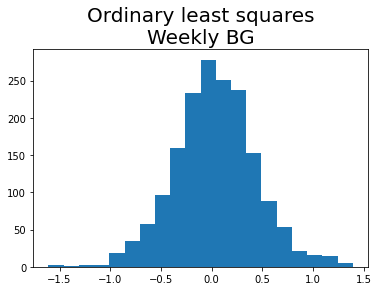

In [13]:
olsfit = LinearRegression().fit(X=X_all, y=y_cont)
plt.hist(olsfit.coef_, bins=20)
plt.title('Ordinary least squares\nWeekly BG', fontsize=20);

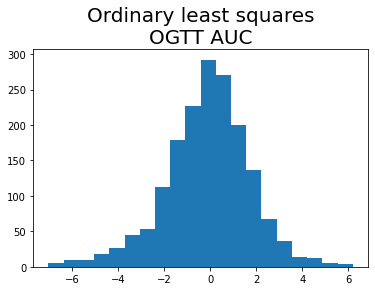

In [12]:
olsfit = LinearRegression().fit(X=X_all, y=y_ogtt)
plt.hist(olsfit.coef_, bins=20)
plt.title('Ordinary least squares\nOGTT AUC', fontsize=20);

Text(0.5, 1.0, 'Elastic net (0.5)\nWeekly BG')

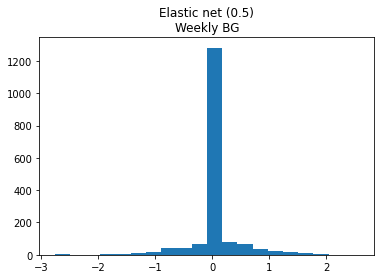

In [18]:
en_bg = ElasticNet(tol=1e-4, max_iter=20000).fit(X=X_all, y=y_cont)
plt.hist(en_bg.coef_, bins=20)
plt.title('Elastic net (0.5)\nWeekly BG')

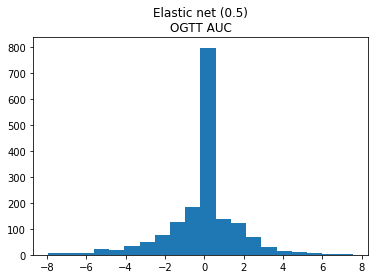

In [19]:
enogtt = ElasticNet(tol=1e-4, max_iter=20000).fit(X=X_all, y=y_ogtt)
plt.hist(enogtt.coef_, bins=20)
plt.title('Elastic net (0.5)\nOGTT AUC');

In [20]:
# enc --> "Elastic Net Coefficients"
enc = pd.DataFrame([enogtt.coef_, data.index, data['Unique ID']]).T
enc.columns = ['coef', 'metab', 'id']
enc
enc.loc[enc['coef'].abs() > 1.3].sort_values('coef', ascending=False, key=abs)

,coef,metab,id
1623,-7.927592,m_325,unknown_540.36605_2.831
1234,-7.859698,m_311,unknown_105.01821_11.985
1630,-7.664694,m_109,unknown_512.33489_2.902
937,-7.622068,l_937,unknown_1053.93054_17.85
955,7.538087,l_955,unknown_1896.745_18.11
...,...,...,...
1721,-1.319229,m_557,unknown_150.05839_9.886
323,-1.318976,l_323,SM_d36:2_729.5907_8.622
1300,-1.318086,m_156,unknown_92.92693_12.76
1557,-1.317807,m_430,unknown_548.37218_2.283


Text(0.5, 1.0, 'Lasso (L1) least squares\nOGTT AUC')

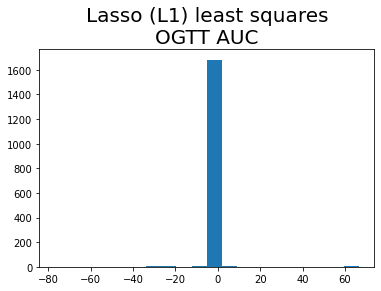

In [26]:
lassoogtt = ElasticNet(tol=1e-4, max_iter=20000, l1_ratio=1).fit(X=X_all, y=y_ogtt)
plt.hist(lassoogtt.coef_, bins=20)
plt.title('Lasso (L1) least squares\nOGTT AUC', fontsize=20)

Text(0.5, 1.0, 'Ridge (L2) least squares')

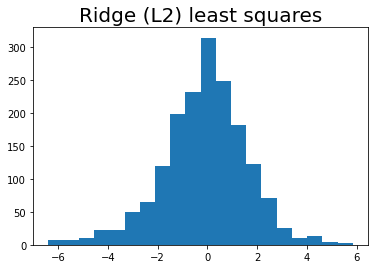

In [28]:
ridgeogtt = ElasticNet(tol=1e-4, max_iter=100000, l1_ratio=0.02).fit(X=X_all, y=y_ogtt)
# pure Ridge (L1_ratio = 0) doesn't converge even for 100k iterations. See ElasticNet docs that <0.01 is unstable!
plt.hist(ridgeogtt.coef_, bins=20)
plt.title('Ridge (L2) least squares', fontsize=20)

## Cross-validate elastic net alpha and L1_ratio parameters

In [39]:
encv = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99], 
    max_iter=20000,
    cv=60,
    n_jobs=7,
    random_state=1
).fit(X=X_all, y=y_ogtt)

In [40]:
print(encv.l1_ratio_)
print(encv.alpha_)
print(encv.dual_gap_)
print(encv.alphas_)

0.85
0.4120510084512447
21.68572513830305
[[3.50243357e+03 3.26638127e+03 3.04623811e+03 ... 4.02694750e+00
  3.75554472e+00 3.50243357e+00]
 [1.16747786e+03 1.08879376e+03 1.01541270e+03 ... 1.34231583e+00
  1.25184824e+00 1.16747786e+00]
 [7.00486714e+02 6.53276254e+02 6.09247621e+02 ... 8.05389500e-01
  7.51108943e-01 7.00486714e-01]
 ...
 [3.68677218e+02 3.43829608e+02 3.20656643e+02 ... 4.23889211e-01
  3.95320496e-01 3.68677218e-01]
 [3.61075626e+02 3.36740337e+02 3.14045166e+02 ... 4.15149227e-01
  3.87169558e-01 3.61075626e-01]
 [3.53781169e+02 3.29937502e+02 3.07700819e+02 ... 4.06762374e-01
  3.79347951e-01 3.53781169e-01]]


## EN CV with either cv=10 or cv=60 come to the same conclusion: 
# use L1 ratio = 0.85 and alpha = 0.412

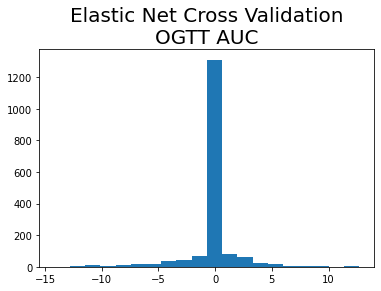

In [44]:
plt.title('Elastic Net Cross Validation\nOGTT AUC', fontsize=20)
plt.hist(encv.coef_, bins=20);

In [46]:
coefs = pd.DataFrame([ols.coef_, ridgefit.coef_, lassofit.coef_, encv.coef_, 
                      data.index, data['Unique ID']]).T
coefs.columns = ['ols', 'ridge', 'lasso', 'encv', 'i', 'id']
coefs
# coefs.loc[coefs['coef'].abs() > 1.3].sort_values('coef', ascending=False, key=abs)

,ols,ridge,lasso,encv,i,id
0,0.32479,-0.928348,-0.0,-0.0,l_0,unknown_679.05463_0.536
1,0.515974,-0.311146,-0.0,-0.0,l_1,unknown_641.1087_0.537
2,0.44203,-0.218999,-0.0,-0.0,l_2,unknown_951.15973_0.541
3,0.399679,-3.178691,-0.0,-4.560461,l_3,unknown_329.03067_0.542
4,0.75366,-0.957431,-0.0,-0.0,l_4,unknown_969.13147_0.544
...,...,...,...,...,...,...
1722,-0.3076,-4.389301,-0.0,-6.089514,m_169,unknown_174.00102_9.94
1723,-0.087114,-1.187415,0.0,-0.0,m_213,unknown_187.04097_9.971
1724,-0.263106,-2.081337,0.0,-0.0,m_24,DL-Lactic Acid_89.02331_9.99
1725,-0.194991,-1.413319,0.0,-0.0,m_505,unknown_313.051_9.991


In [57]:
# coefs.to_csv(r'..\data\processed\ElasticNetCV_feature_importance.csv')

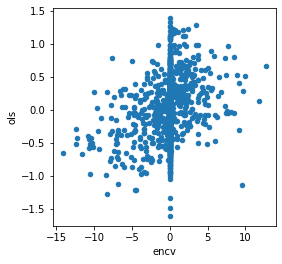

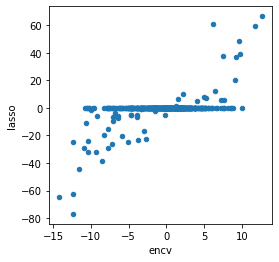

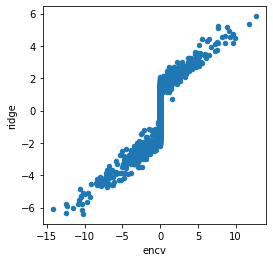

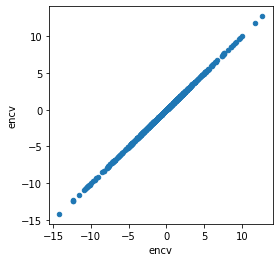

In [47]:
for m in ['ols', 'lasso', 'ridge', 'encv']: 
    coefs.plot.scatter('encv', m, figsize=(4,4))

In [56]:
# Lasso only finds less than 100 features that are significant
coefs.loc[coefs['lasso'] != 0].shape[0]

58

In [49]:
coefs.sort_values('encv', key=abs, ascending=False).head(60)

,ols,ridge,lasso,encv,i,id
1234,-0.655429,-6.10089,-64.862969,-14.156491,m_311,unknown_105.01821_11.985
955,0.666167,5.837894,66.614235,12.690879,l_955,unknown_1896.745_18.11
1680,-0.519764,-5.74839,-76.957384,-12.40445,m_37,Betaine_118.08656_8.574
1623,-0.285122,-6.318296,-24.672861,-12.390605,m_325,unknown_540.36605_2.831
1560,-0.422481,-5.929399,-62.333089,-12.302822,m_532,unknown_553.28308_2.288
572,0.136084,5.364043,59.68031,11.760136,l_572,Plasmanyl-PC_O-20:0_20:4_824.6543_11.065
881,-0.6659,-6.03647,-44.287753,-11.549257,l_881,unknown_378.15372_17.064
265,-0.402437,-5.755154,-29.246969,-10.874832,l_266,unknown_589.461_8.135
1678,-0.58392,-5.502349,-0.0,-10.733531,m_391,unknown_176.1394_8.572
1030,-0.442143,-4.857413,-11.151849,-10.642771,m_449,unknown_509.32935_1.373


In [52]:
coefs.loc[coefs['encv'].abs() > 0.0, ['encv', 'i', 'id']].sort_values('encv', ascending=False, key=abs)

,encv,i,id
1234,-14.156491,m_311,unknown_105.01821_11.985
955,12.690879,l_955,unknown_1896.745_18.11
1680,-12.40445,m_37,Betaine_118.08656_8.574
1623,-12.390605,m_325,unknown_540.36605_2.831
1560,-12.302822,m_532,unknown_553.28308_2.288
...,...,...,...
757,0.02981,l_757,unknown_932.76953_15.21
709,0.028349,l_709,unknown_980.77069_14.124
1404,-0.015362,m_666,unknown_425.92696_14.858
1472,-0.01459,m_380,unknown_546.95557_16.086


# Statsmodels Elastic Net 
## Does not work

In [53]:
encv.mse_path_[:, :, 0][1]

array([497247.2790836 , 497217.71023068, 497098.6717922 , 496717.72009571,
       495823.59241196, 494492.11495747, 492561.69215763, 490171.97168444,
       487177.52343717, 483838.59147157, 480534.91291987, 477156.48548096,
       473687.1597318 , 470568.80878924, 467781.0249742 , 465274.84261526,
       462832.8443009 , 460426.07909787, 457867.30423402, 455412.97439136,
       452776.3329707 , 450314.21348698, 448103.48914911, 445686.6588039 ,
       443019.37826805, 439900.07373542, 436506.79514256, 433040.27091728,
       429546.31252648, 425978.31628132, 422283.07868695, 418316.24826618,
       414254.89955364, 410168.30110657, 405708.60709238, 400902.45911531,
       395965.56768199, 390941.21933506, 385696.82633418, 380353.54841253,
       374701.75951615, 368952.82546516, 363054.1318732 , 356893.52400678,
       350696.49782566, 344578.07217656, 338586.79457847, 332645.92986743,
       326817.16231813, 321091.39658494, 315527.54730677, 310165.35498842,
       304840.74209636, 2

In [39]:
exog = fg.set_index('combined_col_name')['glucose_tolerance']
exog

combined_col_name
1076_10_FBG    diabetic
1062_8_FBG     impaired
1093_9_FBG       normal
1060_8_RBG     impaired
1091_10_FBG      normal
1092_9_RBG     impaired
1093_10_RBG      normal
1082_10_FBG    diabetic
1060_9_RBG     impaired
1101_9_FBG     diabetic
1062_10_RBG    impaired
1091_8_RBG       normal
1074_10_FBG    impaired
1101_10_RBG    diabetic
1076_9_FBG     diabetic
1092_9_FBG     impaired
1074_8_FBG     impaired
1091_10_RBG      normal
1082_9_FBG     diabetic
1076_8_RBG     diabetic
1060_8_FBG     impaired
1093_9_RBG       normal
1060_10_FBG    impaired
1082_10_RBG    diabetic
1074_9_RBG     impaired
1091_9_RBG       normal
1101_10_FBG    diabetic
1093_8_FBG       normal
1074_8_RBG     impaired
1102_10_RBG    impaired
1062_9_FBG     impaired
1076_9_RBG     diabetic
1092_8_FBG     impaired
1062_10_FBG    impaired
1102_8_RBG     impaired
1074_10_RBG    impaired
1060_9_FBG     impaired
1082_9_RBG     diabetic
1076_10_RBG    diabetic
1091_9_FBG       normal
1102_9_FBG     impaire

In [36]:
endog = df.set_index('i')[data_cols].T

In [37]:
abbrev_cols = endog.columns

In [40]:
endog.join(exog)

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_1020,l_1021,l_1022,l_1023,l_1024,l_1025,l_1026,l_1027,l_1028,glucose_tolerance
1076_10_FBG,29.163795,30.152274,29.735454,29.701370,26.700629,28.721319,29.803012,29.047350,28.892166,27.170732,...,18.378388,18.336840,18.447194,16.419472,18.897008,16.810111,17.724121,18.400646,16.655211,diabetic
1062_8_FBG,30.572489,30.703658,29.569621,30.641931,21.774699,27.427681,30.349551,28.813080,28.671019,26.901321,...,17.166214,17.882779,19.507955,17.567143,19.348489,17.364343,19.240306,18.585339,16.313637,impaired
1093_9_FBG,29.753802,30.603359,30.043032,30.624242,27.051667,28.906704,30.228474,29.137348,28.609728,26.578356,...,21.175953,20.788956,21.407793,21.111930,21.529536,20.099612,21.430516,20.968101,19.339229,normal
1060_8_RBG,30.610134,29.309067,29.827946,28.459047,17.431244,29.295561,29.113441,28.848762,28.995708,22.512901,...,20.310682,19.423127,20.589383,18.430226,17.921098,18.430542,17.488155,16.202162,17.985491,impaired
1091_10_FBG,30.700893,30.505310,29.420633,30.636897,27.163433,28.470314,30.188475,28.977544,28.105805,26.149719,...,17.710758,18.448910,19.899861,18.266873,20.133479,17.986741,19.996615,19.778245,17.357845,normal
1092_9_RBG,30.577914,29.114748,29.483693,28.588431,25.867137,29.644309,29.046819,28.993620,28.339876,22.618105,...,18.375462,18.748319,19.968825,18.419951,17.824376,18.099621,17.383197,15.556400,17.582655,impaired
1093_10_RBG,30.656929,29.416945,29.886091,28.685024,26.188412,29.792770,29.130352,29.043613,28.603652,22.397004,...,18.989137,19.227975,20.089886,18.323302,18.836779,18.145468,18.282680,16.603878,17.887551,normal
1082_10_FBG,30.604336,30.081204,29.609038,30.257619,26.977695,28.204534,29.891213,28.981538,28.704319,27.005622,...,16.566651,15.513664,18.843156,15.364329,19.255315,14.496938,19.507853,19.379093,13.846921,diabetic
1060_9_RBG,30.996475,29.431175,30.018239,28.625995,26.312933,30.211206,29.212933,29.416956,29.331185,22.829664,...,19.661018,19.568500,20.581856,18.948519,18.261890,18.854601,17.718258,16.494586,18.466842,impaired
1101_9_FBG,30.672859,30.044828,29.620839,29.974868,26.709748,28.574011,29.729036,29.041379,28.488075,26.715388,...,19.419490,19.099508,20.166937,19.286479,19.685160,18.324624,19.526233,18.844052,17.739443,diabetic


In [91]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x ** 2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

X = sm.add_constant(X)
y = np.dot(X, beta) + e

X

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01010101e-01, 1.02030405e-02],
       [1.00000000e+00, 2.02020202e-01, 4.08121620e-02],
       [1.00000000e+00, 3.03030303e-01, 9.18273646e-02],
       [1.00000000e+00, 4.04040404e-01, 1.63248648e-01],
       [1.00000000e+00, 5.05050505e-01, 2.55076013e-01],
       [1.00000000e+00, 6.06060606e-01, 3.67309458e-01],
       [1.00000000e+00, 7.07070707e-01, 4.99948985e-01],
       [1.00000000e+00, 8.08080808e-01, 6.52994592e-01],
       [1.00000000e+00, 9.09090909e-01, 8.26446281e-01],
       [1.00000000e+00, 1.01010101e+00, 1.02030405e+00],
       [1.00000000e+00, 1.11111111e+00, 1.23456790e+00],
       [1.00000000e+00, 1.21212121e+00, 1.46923783e+00],
       [1.00000000e+00, 1.31313131e+00, 1.72431385e+00],
       [1.00000000e+00, 1.41414141e+00, 1.99979594e+00],
       [1.00000000e+00, 1.51515152e+00, 2.29568411e+00],
       [1.00000000e+00, 1.61616162e+00, 2.61197837e+00],
       [1.00000000e+00, 1.71717

In [92]:
exog.values.reshape(1, -1)

array([['diabetic', 'impaired', 'normal', 'impaired', 'normal',
        'impaired', 'normal', 'diabetic', 'impaired', 'diabetic',
        'impaired', 'normal', 'impaired', 'diabetic', 'diabetic',
        'impaired', 'impaired', 'normal', 'diabetic', 'diabetic',
        'impaired', 'normal', 'impaired', 'diabetic', 'impaired',
        'normal', 'diabetic', 'normal', 'impaired', 'impaired',
        'impaired', 'diabetic', 'impaired', 'impaired', 'impaired',
        'impaired', 'impaired', 'diabetic', 'diabetic', 'normal',
        'impaired', 'impaired', 'normal', 'diabetic', 'impaired',
        'diabetic', 'impaired', 'diabetic', 'diabetic', 'normal',
        'impaired', 'diabetic', 'impaired', 'impaired', 'normal',
        'impaired', 'impaired', 'diabetic', 'impaired', 'impaired']],
      dtype=object)

In [76]:
np.asarray(exog)

array(['diabetic', 'impaired', 'normal', 'impaired', 'normal', 'impaired',
       'normal', 'diabetic', 'impaired', 'diabetic', 'impaired', 'normal',
       'impaired', 'diabetic', 'diabetic', 'impaired', 'impaired',
       'normal', 'diabetic', 'diabetic', 'impaired', 'normal', 'impaired',
       'diabetic', 'impaired', 'normal', 'diabetic', 'normal', 'impaired',
       'impaired', 'impaired', 'diabetic', 'impaired', 'impaired',
       'impaired', 'impaired', 'impaired', 'diabetic', 'diabetic',
       'normal', 'impaired', 'impaired', 'normal', 'diabetic', 'impaired',
       'diabetic', 'impaired', 'diabetic', 'diabetic', 'normal',
       'impaired', 'diabetic', 'impaired', 'impaired', 'normal',
       'impaired', 'impaired', 'diabetic', 'impaired', 'impaired'],
      dtype=object)

In [133]:
en = sm.OLS(endog=endog, exog=exog.values.reshape(1, -1)).fit_regularized(L1_wt=0.5)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [126]:
formula

'C(glucose_tolerance) ~ m_0 + m_1 + m_2 + m_3 + m_4 + m_5 + m_6 + m_7 + m_8 + m_9 + m_10 + m_11 + m_12 + m_13 + m_14 + m_15 + m_16 + m_17 + m_18 + m_19 + m_20 + m_21 + m_22 + m_23 + m_24 + m_25 + m_26 + m_27 + m_28 + m_29 + m_30 + m_31 + m_32 + m_33 + m_34 + m_35 + m_36 + m_37 + m_38 + m_39 + m_40 + m_41 + m_42 + m_43 + m_44 + m_45 + m_46 + m_47 + m_48 + m_49 + m_50 + m_51 + m_52 + m_53 + m_54 + m_55 + m_56 + m_57 + m_58 + m_59 + m_60 + m_61 + m_62 + m_63 + m_64 + m_65 + m_66 + m_67 + m_68 + m_69 + m_70 + m_71 + m_72 + m_73 + m_74 + m_75 + m_76 + m_77 + m_78 + m_79 + m_80 + m_81 + m_82 + m_83 + m_84 + m_85 + m_86 + m_87 + m_88 + m_89 + m_90 + m_91 + m_92 + m_93 + m_94 + m_95 + m_96 + m_97 + m_98 + m_99 + m_100 + m_101 + m_102 + m_103 + m_104 + m_105 + m_106 + m_107 + m_108 + m_109 + m_110 + m_111 + m_112 + m_113 + m_114 + m_115 + m_116 + m_117 + m_118 + m_119 + m_120 + m_121 + m_122 + m_123 + m_124 + m_125 + m_126 + m_127 + m_128 + m_129 + m_130 + m_131 + m_132 + m_133 + m_134 + m_135 

In [132]:
formula = "glucose_tolerance ~ "  # +  "m_0 + m_1 + m_2"
for metab in abbrev_cols:
    formula += str(metab) + ' + '
formula = formula[:-10001]

en = smf.ols(formula=formula, data=endog.join(exog)).fit_regularized(L1_wt=0.5)    #.fit_regularized(L1_wt=0.5)   # family=sm.families.Binomial()

ValueError: operands could not be broadcast together with shapes (60,3) (60,) 

In [68]:
from numpy.distutils.system_info import get_info
print(get_info('blas_opt'))
print(get_info('lapack_opt'))

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl
Could not locate executable gfortran
Could not locate executable f95
Could not locate executable g95
Could not locate executable efort
Could not locate executable efc
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'
{}
{}


C:\Users\ben\Anaconda3\lib\site-packages\numpy\distutils\system_info.py:2026: UserWarning: 
    Optimized (vendor) Blas libraries are not found.
    Falls back to netlib Blas library which has worse performance.
    A better performance should be easily gained by switching
    Blas library.
  if self._calc_info(blas):
C:\Users\ben\Anaconda3\lib\site-packages\numpy\distutils\system_info.py:2026: UserWarning: 
    Blas (http://www.netlib.org/blas/) libraries not found.
    Directories to search for the libraries can be specified in the
    numpy/distutils/site.cfg file (section [blas]) or by setting
    the BLAS environment variable.
  if self._calc_info(blas):
C:\Users\ben\Anaconda3\lib\site-packages\numpy\distutils\system_info.py:2026: UserWarning: 
    Blas (http://www.netlib.org/blas/) sources not found.
    Directories to search for the sources can be specified in the
    numpy/distutils/site.cfg file (section [blas_src]) or by setting
    the BLAS_SRC environment variable.
  if sel

## StatsModels Least Squares with regularization


In [4]:
# sm_ols = sm.OLS(exog=X_only_signf, endog=y_continuous)
# sm_fit = sm_ols.fit_regularized(L1_wt=0.5, maxiter=10000)

In [5]:
# plt.hist(sm_fit.params)